<a href="https://colab.research.google.com/github/azarkiel/PercepcionComputacional/blob/main/Actividad3_segmentadores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Actividad 3: Evaluación de la segmentación
#### Autor: Francisco Rubén Arenas Hernán

El objetivo de esta actividad es la segmentación de imágenes para serparar objetos de fondo o background. Concretamente se ha focalizado en la segmentación de imágenes de monedas colocadas sobre fondo oscuro. Se han seleccionado de internet cuatro imágenes con estas características. El código desarrollado ha sido creado a partir del ejemplo del tutorial de scikit-image y de las herramientas estudiadas en las actividades anteriores. La evaluación de la segmentación ha sido desarrollada a partir del tutorial de scikit-image de métricas de evaluación.
<p>Para el desarrollo de esta tercera actividad se han construido tres métodos de segmentación diferentes: 

1.   ``método de segmentación basado en umbralización``
2.   ``método de segmentación basado en regiones``
3.   ``método de segmentación basado en contornos``

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import data, exposure
from skimage.exposure import histogram
from skimage.color import rgb2gray
from skimage.color import rgb2grey
%matplotlib inline

## ``Adquisición de imágenes``
Las imagenes seleccionadas se han escogido de internet. Para facilitar el envío y manipulación del notebook por parte del equipo docente se ha optado por la descarga de las imágenes desde el propio notebook. Así todas las imágenes se cargan en memoria a partir sus URLs empleando el comando curl, de forma análoga a las actividades anteriores.

In [2]:
!curl -s -o monedas0.jpg https://johnloomis.org/ece563/notes/BinaryImages/coins/coins3.jpg
!curl -s -o monedas1.jpg https://pyimagesearch.com/wp-content/uploads/2015/10/watershed_coins_01.jpg
!curl -s -o monedas2.jpg https://i.stack.imgur.com/fDUGQ.jpg
!curl -s -o monedas3.jpg https://media.cheggcdn.com/media/f11/f1168b85-30e0-43dd-ad3d-6770a4517193/phpHqs22Y.png
!curl -s -o monedas4.jpg https://media.cheggcdn.com/media/9f8/9f8cf283-1d7b-4c6a-8727-8cf82a04b67f/php9D7V86.png
imagenes = ['monedas0.jpg','monedas1.jpg','monedas2.jpg','monedas3.jpg','monedas4.jpg']

Las imágenes de ``GroundTruth`` empleadas para la evaluación de los segmentadores han sido editadas manualmente empleando la herramienta Photopea. Se han almacenado en un servidor de internet, para ser cargadas en caliente por este notebook con el comando curl. Se han almacenado en una lista en el mismo orden que la lista de ``imagenes``. Así, con el valor de ``indiceImagen`` se accede tanto a la imagen, como a su correspondiente GroundTruth.

A continuación se lee la imagen a tratar de la lista de imagenes definido. Para probar con diferentes imágenes bastará con cambiar el valor de la variable ``indiceImagen`` por un valor entre ``0 y 4``. Como paso preparatorio, la imagen se convierte a escala de grises manteniendo el rango de valores entre ``0-255``.

In [3]:
indiceImagen = 0  # Para probar otras imagenes cambiar el indice por 0,1,2,3 o 4.
imagenOriginal = io.imread(imagenes[indiceImagen])
monedas = (rgb2grey(imagenOriginal)*256).astype('uint8')

## ``1. Método basado en umbralización``

El método basado en umbralización es el método más simple para segmentar imágenes. Se basa en la determinación del valor umbral que dividirá a la imagen en fondo y frente. El valor umbral óptimo depende de los tonos de grises que posean el fondo y las monedas. Para determinarlo se ha estudiado el histograma de cada imagen. Para cada imagen probada se ha escogido un valor umbral óptimo situado entre la montaña correspondiente al fondo y la correspondiente a las monedas. Por lo tanto, para cada imagen se ha establecido su propio valor umbral óptimo. Hay que indicar que este método tiene la contrapartida de que puede pasar por alto partes significativas de las monedas o incluso fusionar partes del fondo con las monedas:



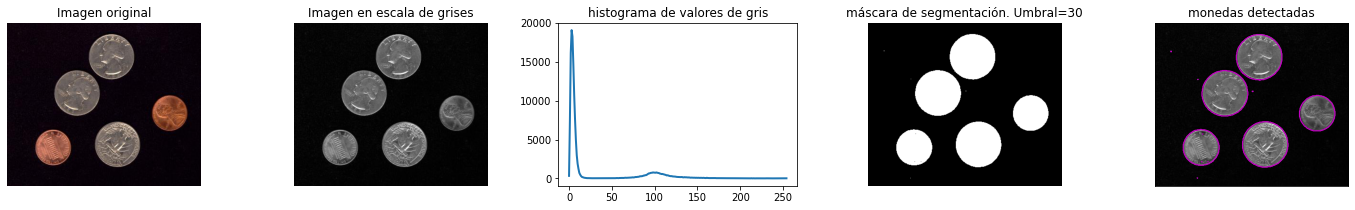

In [4]:
hist, hist_centers = histogram(monedas)
valorUmbral = [30, 105, 85, 80, 115] # Esta lista contiene el valor umbral para cada una de las imágenes.
mascaraUmbralizacion = monedas > valorUmbral[indiceImagen] # Esta máscara será la que utilicemos en la evaluación

plt.figure(figsize=(30,3))
plt.subplot(1,6,1),plt.imshow(imagenOriginal, cmap=plt.cm.gray);plt.title('Imagen original'), plt.axis('off')
plt.subplot(1,6,2),plt.imshow(monedas, cmap=plt.cm.gray);plt.title('Imagen en escala de grises'), plt.axis('off')
plt.subplot(1,6,3),plt.plot(hist_centers, hist, lw=2);plt.title('histograma de valores de gris')
plt.subplot(1,6,4),plt.imshow(mascaraUmbralizacion, cmap=plt.cm.gray);plt.title("máscara de segmentación. Umbral="+str(valorUmbral[indiceImagen])), plt.axis('off')
plt.subplot(1,6,5),plt.imshow(monedas, cmap=plt.cm.gray),plt.contour(mascaraUmbralizacion, [0.5], linewidths=1.2, colors='m');plt.title('monedas detectadas'), plt.xticks([]), plt.yticks([])
plt.show()

## ``2. Segmentación basada en contornos``

A continuación se ha implementado el método para delinear los contornos de las monedas utilizando segmentación basada en contornos. Los pasos que se han seguido son los siguientes:
1.   Obtención de bordes mediante el detector de bordes Canny.
2.   Rellenado mediante operaciones morfológicas de los contornos detectados.
3.   Eliminacion de artefactos espúreos con tamaño mínimo = 22, en caso de existir.

Como se puede ver en la máscara de segmentación los pequeños objetos espureos se eliminan fácilmente estableciendo un tamaño mínimo para los objetos válidos. Sin embargo, tal y como se observa al probar con la imagen ``monedas2.jpg``, este método no es muy robusto. Los contornos que no están perfectamente cerrados no se rellenan correctamente.


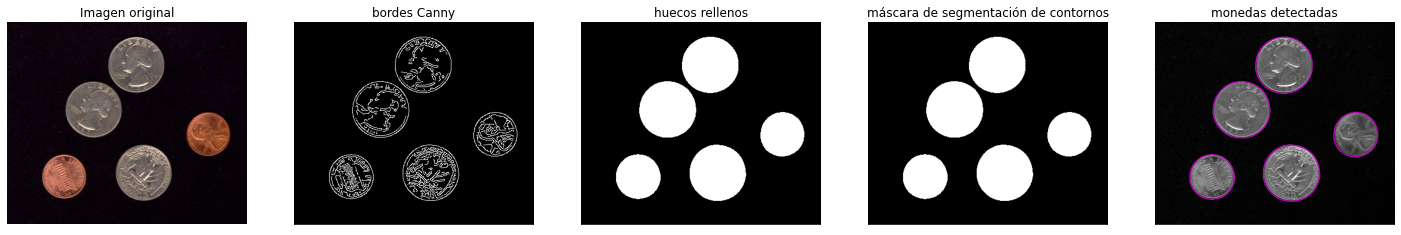

In [5]:
from skimage.feature import canny
from scipy import ndimage as ndi
from skimage.filters import sobel
from skimage import morphology
from skimage import segmentation

bordesCanny = canny(monedas)
fill_coins = ndi.binary_fill_holes(bordesCanny)
mascaraContornos = morphology.remove_small_objects(fill_coins, 22)

plt.figure(figsize=(30,20))
plt.subplot(1,6,1),plt.imshow(imagenOriginal, cmap=plt.cm.gray);plt.title('Imagen original'), plt.axis('off')
plt.subplot(1,6,2),plt.imshow(bordesCanny, cmap=plt.cm.gray);plt.title('bordes Canny'), plt.xticks([]), plt.yticks([])
plt.subplot(1,6,3),plt.imshow(fill_coins, cmap=plt.cm.gray);plt.title('huecos rellenos'), plt.xticks([]), plt.yticks([])
plt.subplot(1,6,4),plt.imshow(mascaraContornos, cmap=plt.cm.gray);plt.title('máscara de segmentación de contornos'), plt.xticks([]), plt.yticks([])
plt.subplot(1,6,5),plt.imshow(monedas, cmap=plt.cm.gray),plt.contour(mascaraContornos, [0.5], linewidths=1.2, colors='m');plt.title('monedas detectadas'), plt.xticks([]), plt.yticks([])
plt.show()

## ``3. Segmentación basada en regiones``
A continuación se ha implementado el método basado en regiones empleando el algoritmo ``Watershed`` presente en scikit-image. Los pasos implementados son los siguientes:
1. Creación de mapa de elevaciones utilizando el gradiente de Sobel de la imagen. 
2. Detección de los marcadores del fondo y las monedas basadas en las partes extremas del histograma de valores de gris. Para todas las imágenes se ha establecido como valor mínimo ``20`` y como valor máximo ``150``.
3. Rellenado mediante el algoritmo Watershed del mapa de elevaciones a partir de los marcadores detectados en el paso anterior.

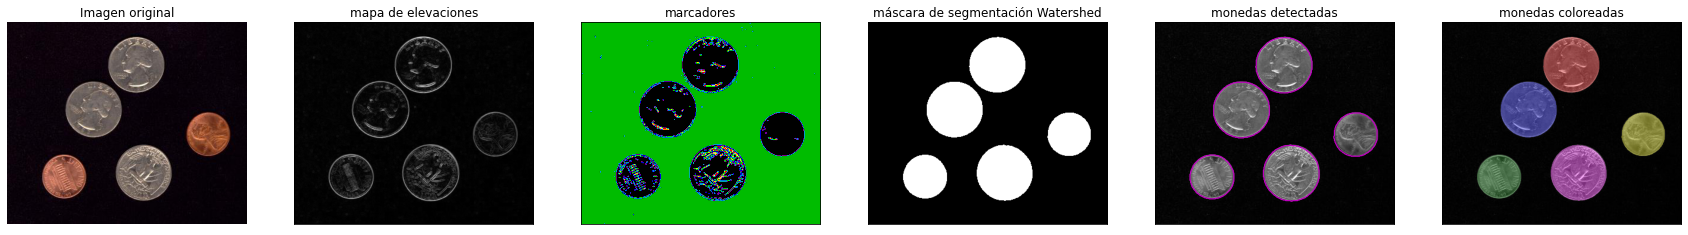

In [6]:
from skimage.color import label2rgb

elevation_map = sobel(monedas)

marcadores = np.zeros_like(monedas)
marcadores[monedas < 20] = 1
marcadores[monedas > 150] = 2

mascaraWatershed = segmentation.watershed(elevation_map, marcadores) #Esta es la máscara que utilizaremos en la evaluación

mascaraWatershed = ndi.binary_fill_holes(mascaraWatershed - 1)
labeled_coins, _ = ndi.label(mascaraWatershed)
image_label_overlay = label2rgb(labeled_coins, image=monedas, bg_label=0)

plt.figure(figsize=(30,20))
plt.subplot(1,6,1),plt.imshow(imagenOriginal, cmap=plt.cm.gray);plt.title('Imagen original'), plt.axis('off')
plt.subplot(1,6,2),plt.imshow(elevation_map, cmap=plt.cm.gray);plt.title('mapa de elevaciones'), plt.xticks([]), plt.yticks([])
plt.subplot(1,6,3),plt.imshow(marcadores, cmap=plt.cm.nipy_spectral);plt.title('marcadores'), plt.xticks([]), plt.yticks([])
plt.subplot(1,6,4),plt.imshow(mascaraWatershed, cmap=plt.cm.gray);plt.title('máscara de segmentación Watershed'), plt.xticks([]), plt.yticks([])
plt.subplot(1,6,5),plt.imshow(monedas, cmap=plt.cm.gray),plt.contour(mascaraWatershed, [0.5], linewidths=1.2, colors='m');plt.title('monedas detectadas'), plt.xticks([]), plt.yticks([])
plt.subplot(1,6,6),plt.imshow(image_label_overlay);plt.title('monedas coloreadas'), plt.xticks([]), plt.yticks([])
plt.show()


Este último método funciona aún mejor y las monedas se pueden segmentar y etiquetar individualmente.





In [7]:
# https://stackoverflow.com/questions/45065469/using-sklearn-metrics-jaccard-index-with-images
# from sklearn.metrics import jaccard_similarity_score

# iouSegUmbralizacion = jaccard_similarity_score(.flatten(), segments_watershed.flatten())
# iouSegContornos = jaccard_similarity_score(img.flatten(), mark_boundaries(img, segments_watershed).flatten())
# iouSegRegiones = jaccard_similarity_score(np.array(img).ravel(), np.array(segments_watershed).ravel())
# print(iou)

Comparing edge-based and region-based segmentation

https://scikit-image.org/docs/stable/auto_examples/applications/plot_coins_segmentation.html